# Coursework for Artificial Intelligence H COMPSCI4004 2024-2025

## Imports

In [1]:
import os, sys
import networkx as nx
# from mazelib import Maze
# from mazelib.generate.Prims import Prims
# import numpy as np
# import random as rand

import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

print("Python version:", sys.version)
print("Networkx version:", nx.__version__)
print("IPyWidgets version:", widgets.__version__)

Python version: 3.13.0 | packaged by Anaconda, Inc. | (main, Oct  7 2024, 21:29:38) [GCC 11.2.0]
Networkx version: 3.4.2
IPyWidgets version: 8.1.5


In [2]:
import maze as m
import solvers as solv
from notebookutils import display_visual

%load_ext autoreload
%autoreload 2

In [3]:
# # To import the AIMA toolbox, add path the to the AIMA Python Toolbox folder on your system
# AIMA_TOOLBOX_ROOT="/home/valeria/Documents/Code/aima-python-uofg_v20202021a"
# sys.path.append(AIMA_TOOLBOX_ROOT)

# import search as sch
# from notebookutils import show_map, display_visual

## Parameters

In [4]:
N = 21 # Number of tiles on the side
M = 6 # Number of wormholes

## Maze Generation

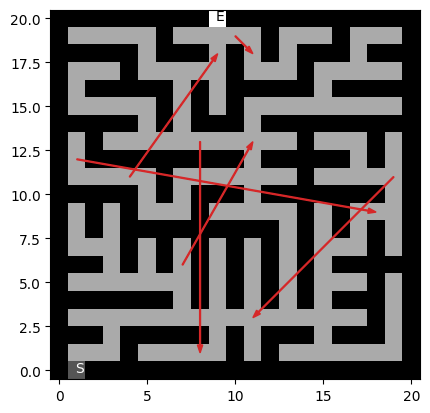

In [5]:
maze_grid, wormholes = m.wormholes_maze_structure(N, M, show_plots=True)


### Graph representation of the maze

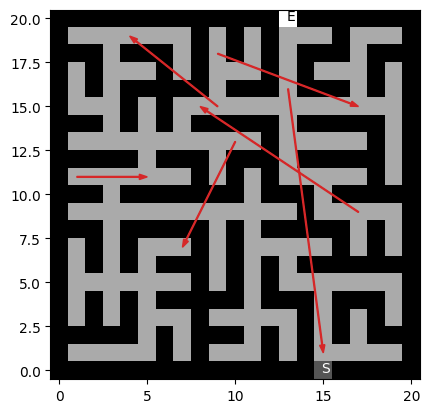

In [6]:
maze_problem = m.wormholes_maze_problem(N, M, show_plots=True)

Important personal interpretation
- I am assuming that going down a teleportation link is optional: e.g. in (2,1) it's possible to go right, go left, or go down the teleportation link.
- I am assuming that the wormholes are two-ways passages: e.g. from (2,1) you can go down the teleportation link to (0,7), and from (0,7) you can go back to (2,1).


- Environment? Besides being discrete and static, it is...
    - Deterministic, because wormholes might lead to an unknown state, but they always lead to the same state with 100% probability.
    - Partially observable, because it is not known from the percepts where the "teleport" action is going to take the agent.
- Actuators? Move the agent according to 5 possible actions:
    - Left
    - Right
    - Up
    - Down
    - Teleport
- Percepts? 
    - Current x,y location
    - Feasibility of all 5 actions, expressed by booleans (l,r,u,d,t)
- Sensors? Incomplete because...
    - The agent knows to which state the (Left, Right, Up, Down) actions take it
    - But the agent does not know to which state the (Teleport) action takes it
- Performance measure? The sortest the path to goal, the better (in terms of steps taken from the start point)

- Branching factor? $b=5$, due to the 5 possible actions; could be optimistically lowered to 3 for most cases, since most tiles are only connected to 2 neighbours.
- Depth of the solution? $d\leq 4(N-2)$ with no teleportation links, effectively less with teleportation links

In [7]:
branching_factor = max([len(v) for (k,v) in maze_problem.graph.graph_dict.items()])
print("Branching factor", branching_factor)

Branching factor 4


In [8]:
print("Unique states/nodes (i.e.locations) and possible actions in those states:\n") 
print(maze_problem.graph.graph_dict)

Unique states/nodes (i.e.locations) and possible actions in those states:

{'S_15_00': {'S_15_01': 1}, 'S_01_01': {'S_02_01': 1}, 'S_02_01': {'S_01_01': 1, 'S_03_01': 1}, 'S_03_01': {'S_02_01': 1, 'S_04_01': 1}, 'S_04_01': {'S_03_01': 1, 'S_05_01': 1}, 'S_05_01': {'S_05_02': 1, 'S_04_01': 1}, 'S_07_01': {'S_07_02': 1}, 'S_09_01': {'S_10_01': 1}, 'S_10_01': {'S_09_01': 1, 'S_11_01': 1}, 'S_11_01': {'S_11_02': 1, 'S_10_01': 1}, 'S_13_01': {'S_13_02': 1}, 'S_15_01': {'S_15_00': 1, 'S_15_02': 1, 'S_16_01': 1}, 'S_16_01': {'S_15_01': 1, 'S_17_01': 1}, 'S_17_01': {'S_17_02': 1, 'S_16_01': 1, 'S_18_01': 1}, 'S_18_01': {'S_17_01': 1, 'S_19_01': 1}, 'S_19_01': {'S_18_01': 1}, 'S_05_02': {'S_05_01': 1, 'S_05_03': 1}, 'S_07_02': {'S_07_01': 1, 'S_07_03': 1}, 'S_11_02': {'S_11_01': 1, 'S_11_03': 1}, 'S_13_02': {'S_13_01': 1, 'S_13_03': 1}, 'S_15_02': {'S_15_01': 1, 'S_15_03': 1}, 'S_17_02': {'S_17_01': 1, 'S_17_03': 1}, 'S_01_03': {'S_01_04': 1}, 'S_03_03': {'S_03_04': 1}, 'S_05_03': {'S_05_02': 1

#### Visualization

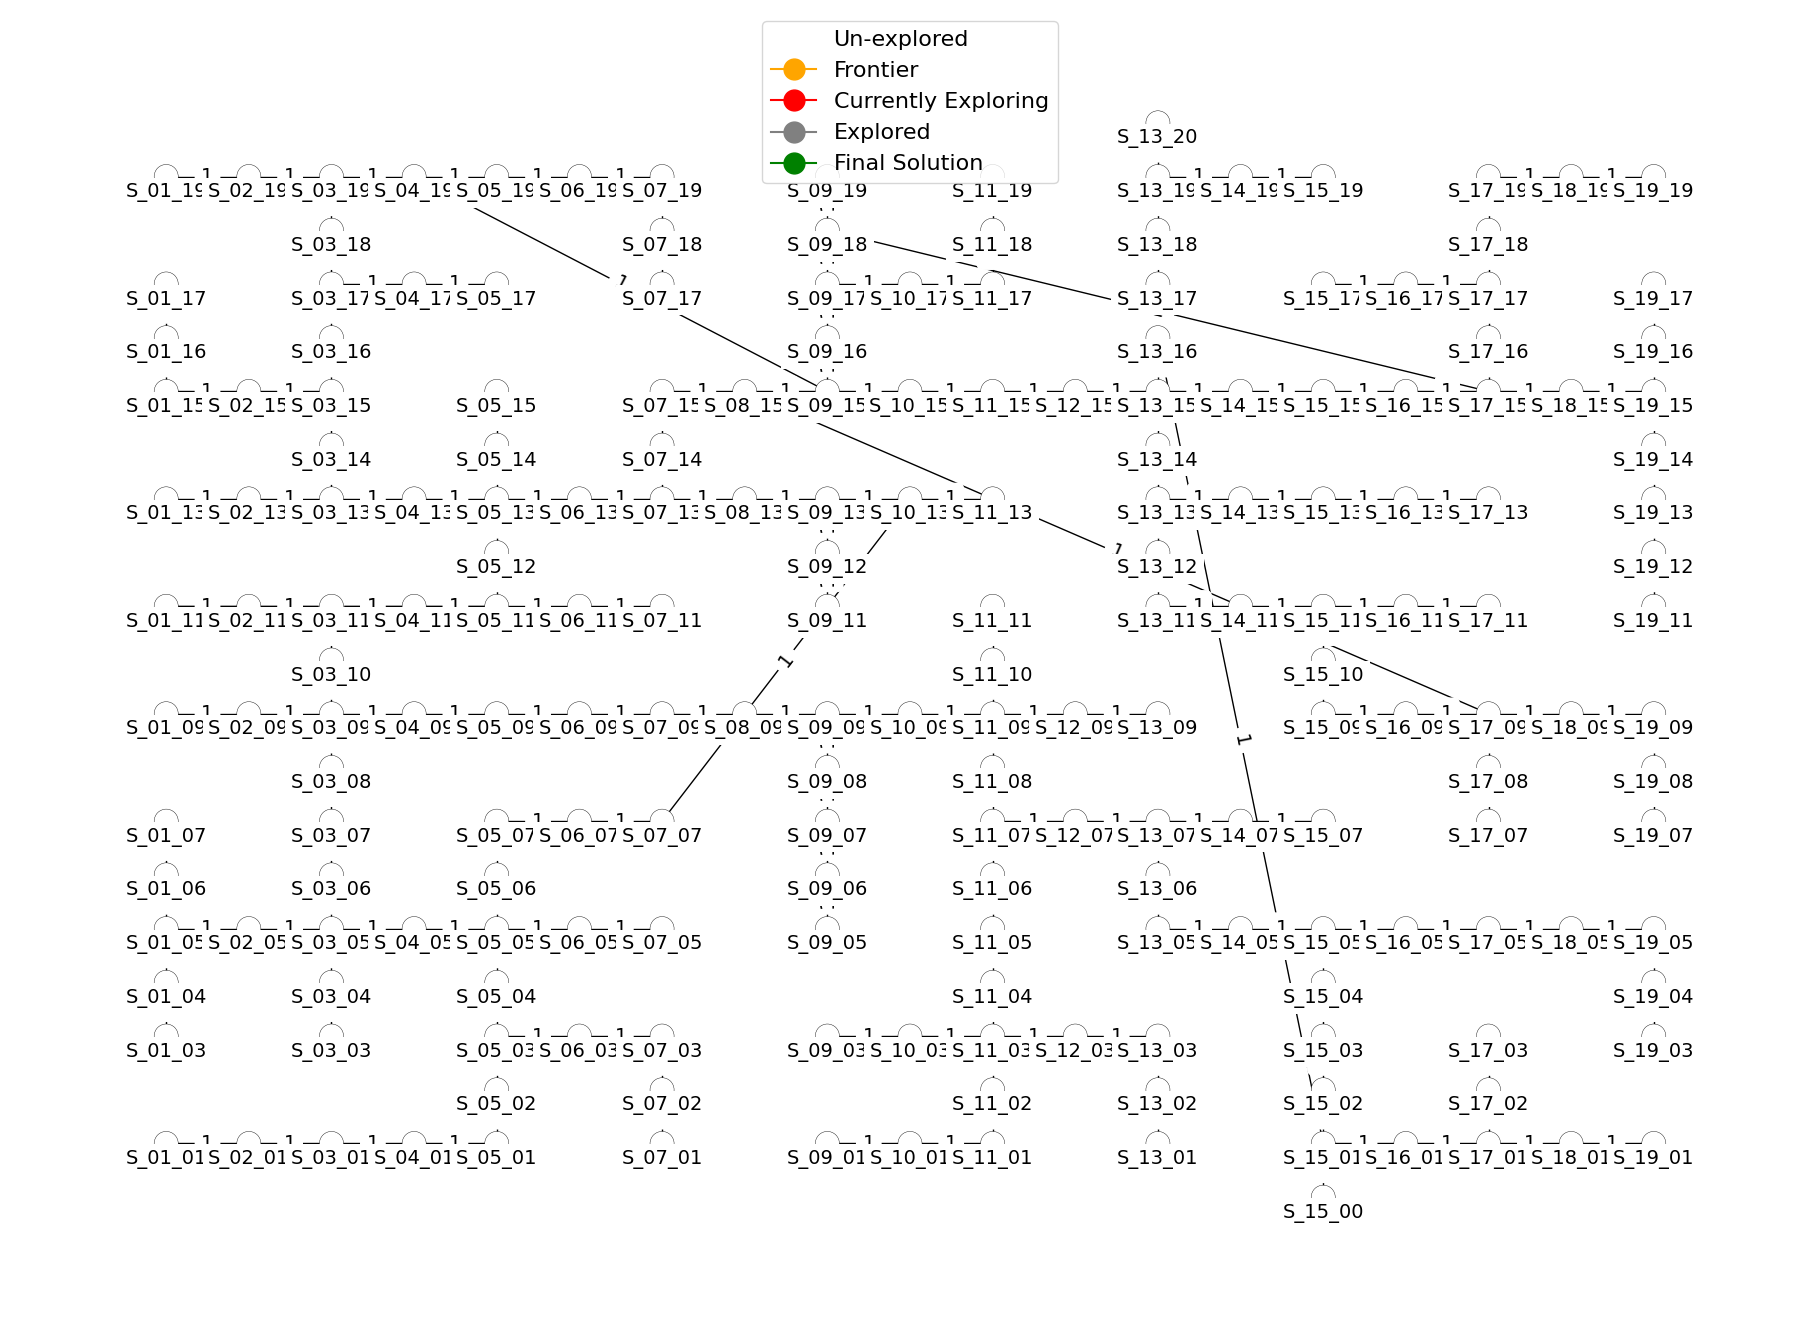

In [9]:
m.show_wormholes_maze_problem(maze_problem)

## Solve the problem (v1.1)

### Define the problem with no knowledge of the wormholes' exit

The **heuristic function** $h$ is an arbitrary, non-negative, problem-specific function with one constrain: if $n$ is a goal node, then $h(n)=0$.

_The tree-search version of A-star is optimal if the heuristic function is **admissible**_. 

A heuristic function is admissible if it never overestimates the cost to reach a goal, i.e. an admissible h is optimistic, returning the estimated cost of the cheapest/shortest path from a state to the goal.

An agent at the start of a teleportation link can choose to go down the wormhole. However, it cannot know in advance where the exit is. _The most optimistic agent going down a wormhole will always assume that a wormhole can take you right to the exit._

_The graph-search version of A-star is optimal if the heuristic function is **consistent**_. 

A heuristic function is consistent if, for every node $n$ and every successor $n'$ of $n$ generated by any action $a$, the estimated cost of reaching the goal from $n$ is no greater than the step cost of getting to $n'$ plus the estimated cost of reaching the goal from $n'$:

$h(n) \leq c(n,a,n') + h(n')$

This is a form of the general triangle inequality. 

"For an admissible heuristic, the inequality makes perfect sense: if there were a route from $n$ to $G_n$ via $n'$ that was cheaper than $h(n)$, that would violate the property that $h()n)$is a lower bound on the cost to reach $G_n$" (Russel, S, & Norvig, P.: _Artificial Intelligence: A Modern Approach_, 3rd edition, Pearson Education, 2010, USA)

If $h$ is admissible, then the values of $f(n)$ along any path are nondecreasing.


After playing around with implementation 1.0, I realized I wasn't updating the preference order of wormholes after discovering them. This implementation 1.1 fixes that.

In [10]:
all_node_colors=[]
iterations, all_node_colors, node = solv.wormholes_maze_A_star_solver(maze_problem)

#-- Trace the solution --#
solution_path = [node]
cnode = node.parent
solution_path.append(cnode)
while cnode.state != maze_problem.initial:
    cnode = cnode.parent  
    solution_path.append(cnode)

print("----------------------------------------")
print("Identified goal state:"+str(solution_path[0]))
print("----------------------------------------")
print("Solution trace:"+str(solution_path))
print("----------------------------------------")


>> Iteration 0 >> Setting up the problem
>> Iteration 1 >> Adding the start point
>> Iteration 2 >> Exploring a node in the frontier
== Node (0, <Node S_15_00>, None) popped out
Will go over the following childs: [<Node S_15_01>]
== Child <Node S_15_01>
>> Iteration 3 >> Adding that child to the frontier
Node position [15  0]
Distance to the goal 22
Added (23, <Node S_15_01>, <Node S_15_00>)
>> Iteration 4 >> Finished exploring a node
Current queue [(23, <Node S_15_01>, <Node S_15_00>)]
>> Iteration 5 >> Exploring a node in the frontier
== Node (23, <Node S_15_01>, <Node S_15_00>) popped out
Will go over the following childs: [<Node S_15_00>, <Node S_15_02>, <Node S_16_01>]
== Child <Node S_15_00>
Child had already been explored
== Child <Node S_15_02>
>> Iteration 6 >> Adding that child to the frontier
Node position [15  1]
Distance to the goal 21
Added (23, <Node S_15_02>, <Node S_15_01>)
== Child <Node S_16_01>
>> Iteration 7 >> Adding that child to the frontier
Node position [15  1

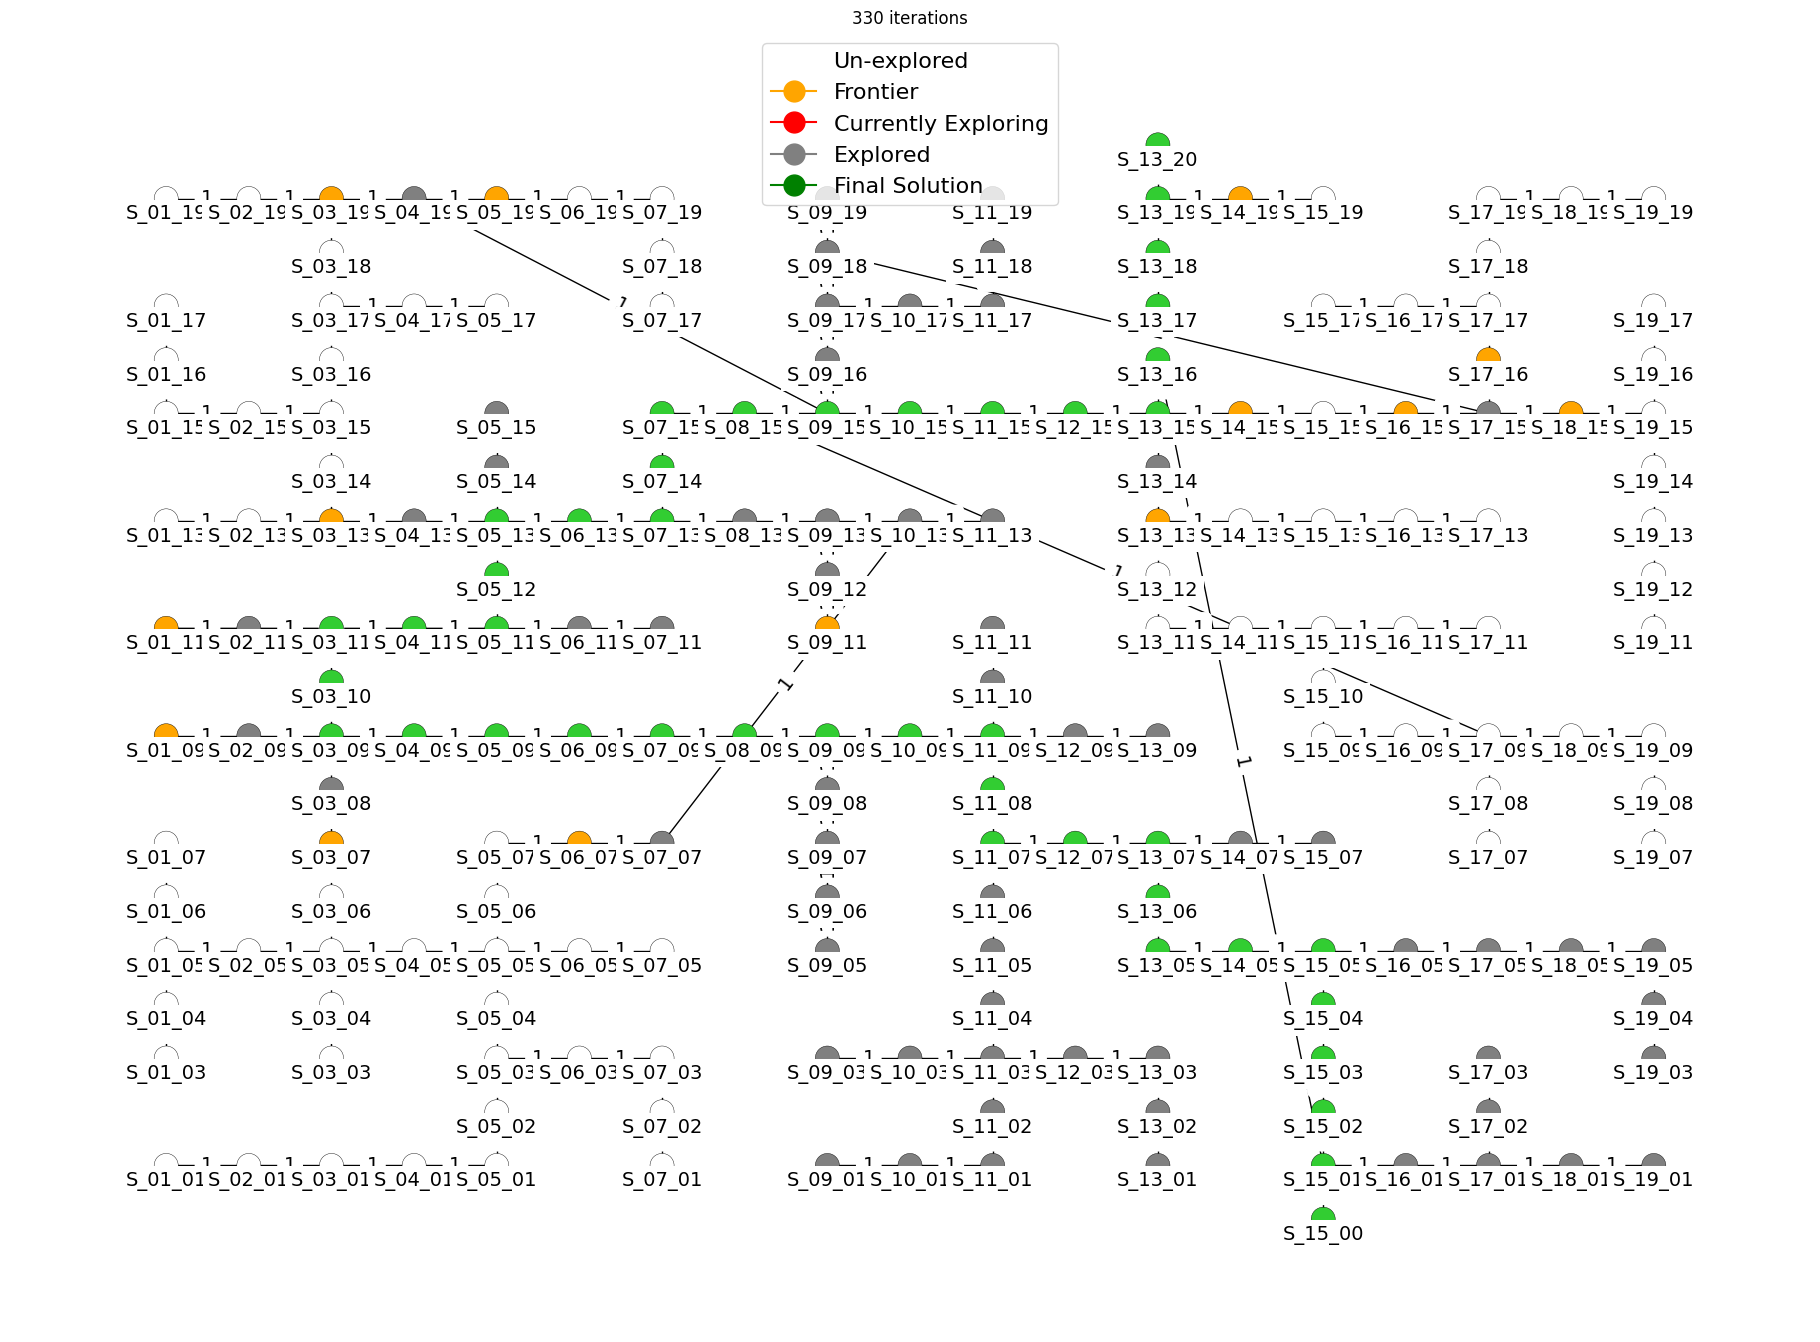

In [11]:
m.show_wormholes_maze_problem(maze_problem, all_node_colors[-1], iterations)

In [12]:
do_full_visualization = False
if do_full_visualization:     
    # WARNING the FULL visualisation might not work very well on some computers due to 
    # the large graph and the many iterations required.The visualisaiton will 
    # typically compute the solution and do the plotting at the end - and it often takes a long time ...
    #
    print("::: Full Visualization ::::")
    maze_problem.verbose = False
    all_node_colors = []        
    display_visual(m.get_wormholes_maze_graphic_data(maze_problem), user_input=False, 
                   algorithm=lambda problem : solv.wormholes_maze_A_star_solver(problem, verbose=False), 
                   problem=maze_problem)
    maze_problem.verbose = True

### Analysis

**I'm now updating my h after exploring the wormhole**

Ouch! Never got to explore the upper path and find the shortcut

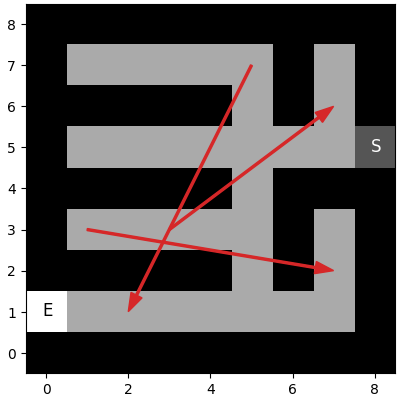

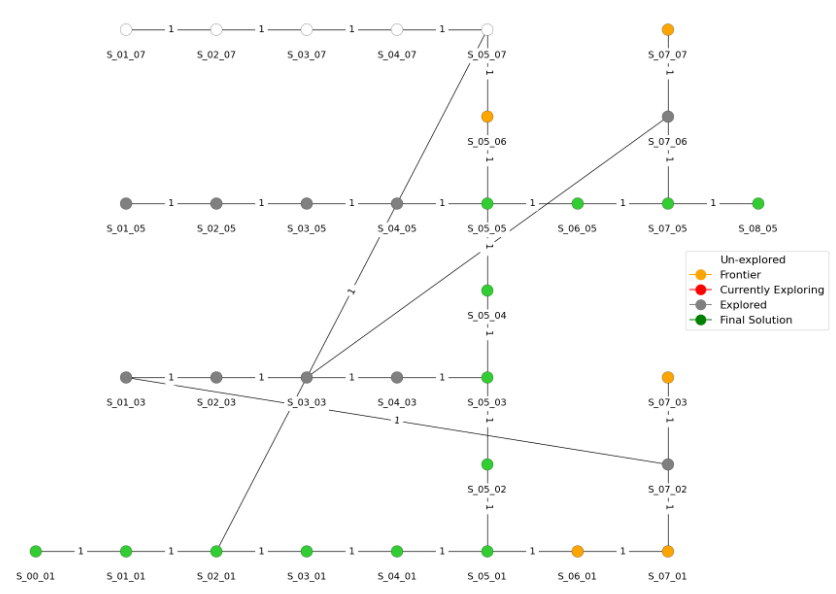

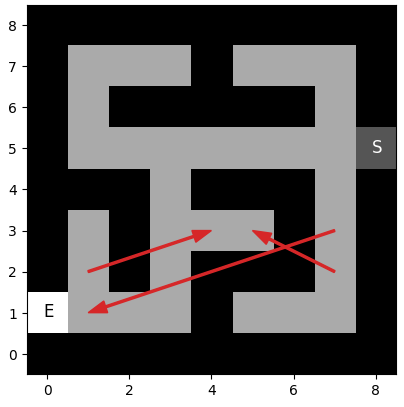

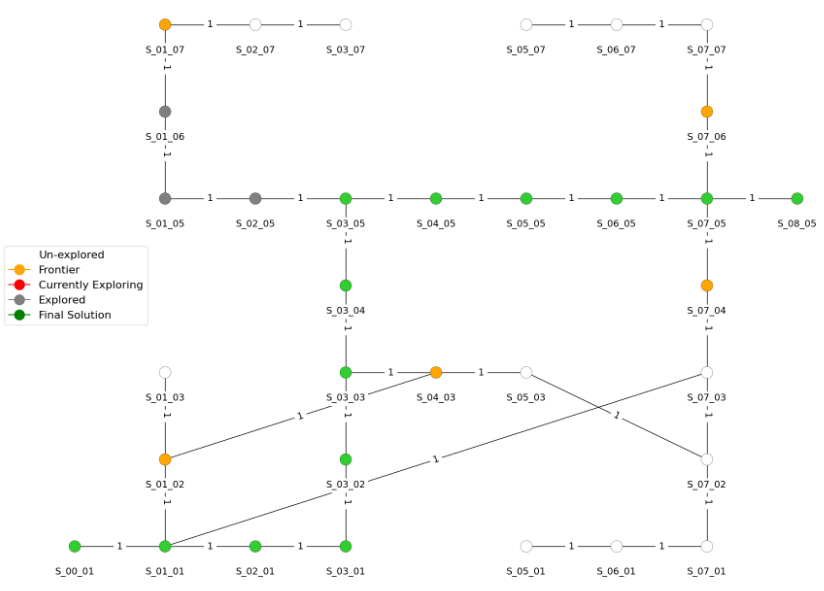

Curiously enough, in this case it was better not to take the wormhole:

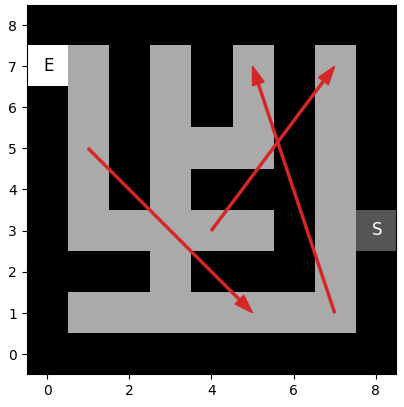

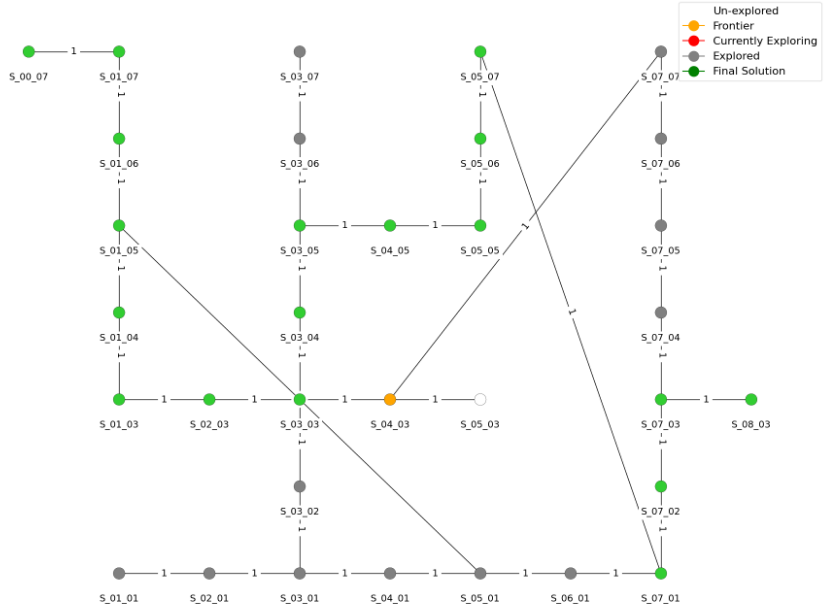

## Solving the problem (v1.0)

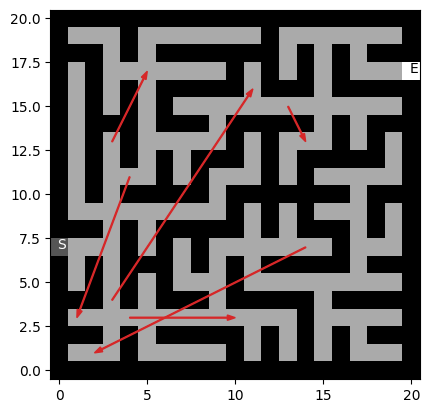

In [13]:
maze_problem = m.wormholes_maze_problem_v0(N, M, show_plots=True)

In [14]:
all_node_colors=[]
iterations, all_node_colors, node = solv.multiple_priority_A_star_h_solver(maze_problem)

#-- Trace the solution --#
solution_path = [node]
cnode = node.parent
solution_path.append(cnode)
while cnode.state != maze_problem.initial:
    cnode = cnode.parent  
    solution_path.append(cnode)

print("----------------------------------------")
print("Identified goal state:"+str(solution_path[0]))
print("----------------------------------------")
print("Solution trace:"+str(solution_path))
print("----------------------------------------")


Node position [0 7]
Distance to the goal 30
Node position [1 7]
Distance to the goal 29
Node position [1 6]
Distance to the goal 30
Node position [2 7]
Distance to the goal 28
Node position [3 7]
Distance to the goal 27
Node position [3 6]
Distance to the goal 28
Node position [3 8]
Distance to the goal 26
Node position [3 9]
Distance to the goal 25
Node position [ 3 10]
Distance to the goal 24
Node position [2 9]
Distance to the goal 26
Node position [4 9]
Distance to the goal 24
Node position [ 3 11]
Distance to the goal 23
Node position [ 3 12]
Distance to the goal 22
Node position [ 4 11]
Distance to the goal 22
Node position [ 3 13]
Distance to the goal 21
Node position [ 5 17]
Teleportation link
Node position [ 5 16]
Distance to the goal 16
Node position [ 5 18]
Distance to the goal 16
Node position [ 4 17]
Distance to the goal 16
Node position [ 6 17]
Distance to the goal 14
Node position [ 7 17]
Distance to the goal 13
Node position [ 8 17]
Distance to the goal 12
Node position

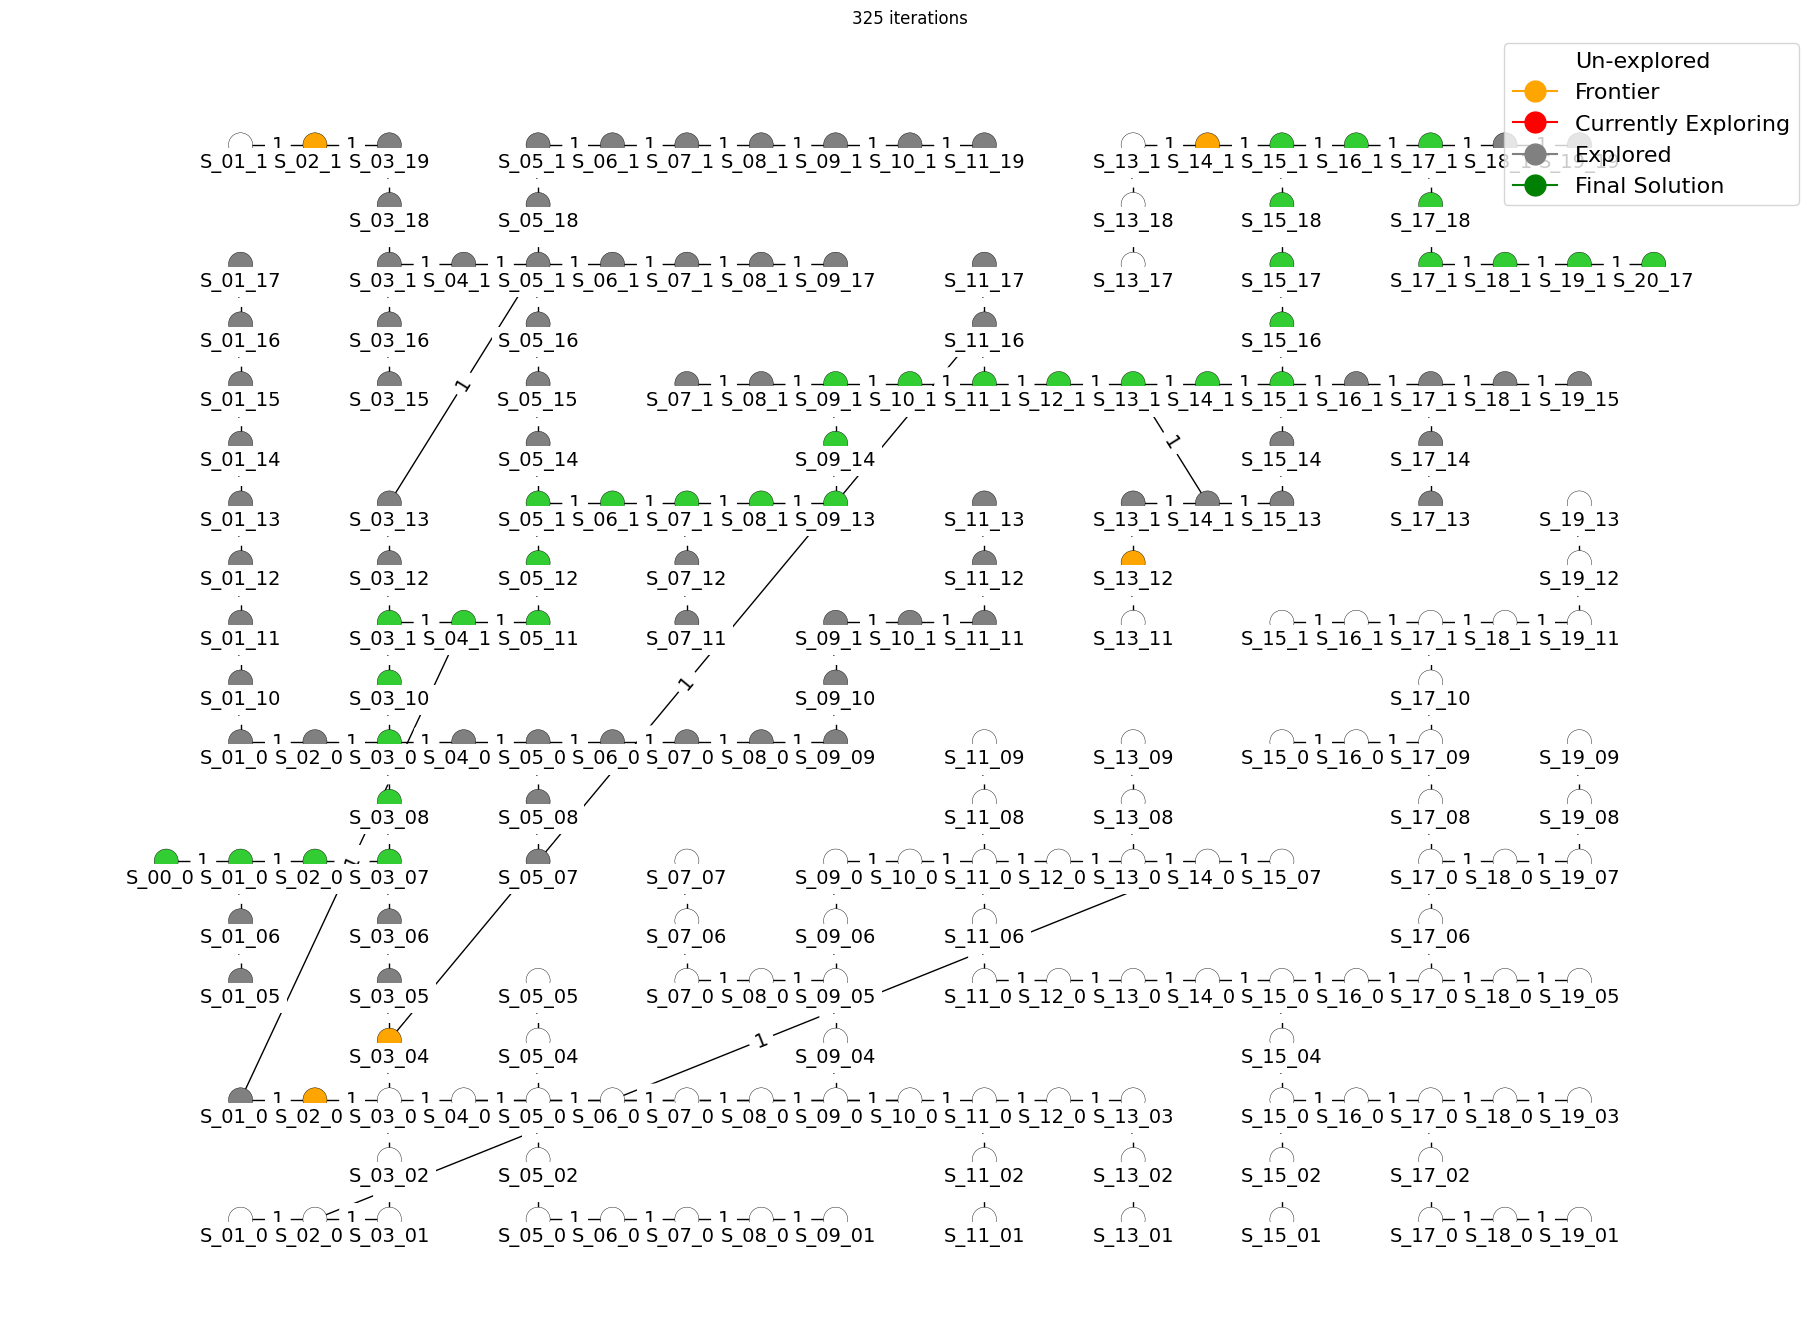

In [15]:
m.show_wormholes_maze_problem(maze_problem, all_node_colors[-1], iterations)

In [16]:
do_full_visualization = False
if do_full_visualization:     
    # WARNING the FULL visualisation might not work very well on some computers due to 
    # the large graph and the many iterations required.The visualisaiton will 
    # typically compute the solution and do the plotting at the end - and it often takes a long time ...
    #
    print("::: Full Visualization ::::")
    maze_problem.verbose = False
    all_node_colors = []        
    display_visual(m.get_wormholes_maze_graphic_data(maze_problem), user_input=False, 
                   algorithm=lambda problem : solv.wormholes_maze_A_star_solver(problem, verbose=False), 
                   problem=maze_problem)
    maze_problem.verbose = True

### Analysis

**I think the problem right now is that I am not updating my h function once I get to know a wormhole's exit.**

Apparently, the solution may not be optimal

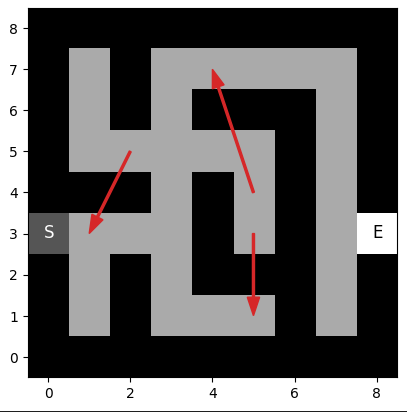

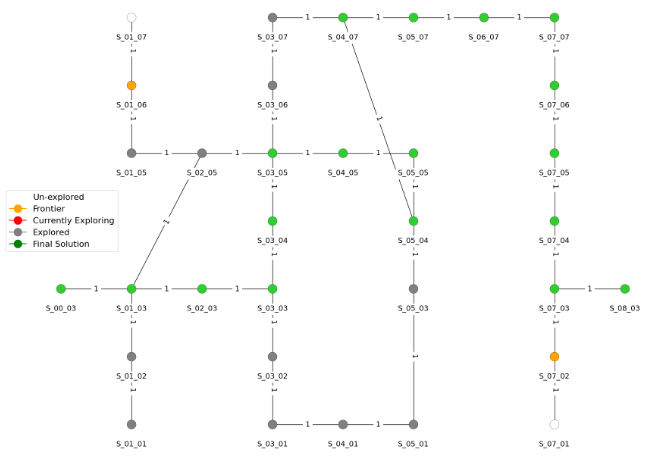

## Some previous ideas

### Solve using the original A-star

The cells below copy the A* implementation from Lab 3, using helper functions from the AIMA toolbox.


In [17]:
def my_best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = sch.memoize(f, 'f')
    node = sch.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "limegreen"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = sch.PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "limegreen"
            node_colors[problem.initial] = "limegreen"
            for extra_node in node.solution():
                node_colors[extra_node] = "limegreen"  
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None


In [18]:
def my_astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass.
    
    Credits to the AI Module lecturers: this function has been 
    taken from Lab 3 and it has not been modified"""
    h = sch.memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = my_best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

### Define the problem using the AIMA toolbox

According to the current setup...
- Cost function f = Accumulated path length, with each step uniformly assigned length 1 (wormholes included)
- Heuristic function h = Euclidian straight-line distance to the maze exit

However, to better represent the estimated remaining distance to the goal, it might be better to use a different distance metric: the sum $|x_{goal}-x| + |y_{goal}-y|$ of the vertical and horizontal distances.

In [19]:
class SquareAngleDistanceGraphProblem(sch.GraphProblem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, *args, verbose=False):
        super().__init__(*args)
        self.verbose = verbose

    def h(self, node):
        """The sum of the horizontal and vertical distance to the goal"""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                state_position = np.array(locs[node])
            else:
                state_position = np.array(locs[node.state])
            goal_position = np.array(locs[self.goal])
            if self.verbose: 
                print("State position", state_position)
                print("Distance to the goal", int( np.sum( np.abs( goal_position - state_position) ) ))
            return int( np.sum( np.abs( goal_position - state_position) ) )
        else:
            return sch.infinity

NameError: name 'sch' is not defined